In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## Paramètres de vol 

In [2]:
Vb = 2
Diametre_bouteille = 8.9
Diametre_sortie = 0.9
Masse_fusee_vide = 0.5 # Mo
Cx = 0.1
a = 89 # prévoir de le transformer en radians pour utiliser les fonctions trigo
lr = 22
Po = 10
Veo = 0.65

## Variables à utiliser et conversions

In [3]:
# Conversion des volumes en mètres cubes
Vb /= 1000
Veo /= 1000
# Conversion de la pression en pascal
Po *= 100000 # press
# Section de la bouteille en m^2
Section_bouteille = (Diametre_bouteille**2)*np.pi/40000
Section_goulot = (Diametre_sortie**2)*np.pi/40000
lr /= 100

In [4]:
Vb

0.002

## Constantes environementales

In [5]:
g = 9.81 # gravité
r = 998 # densité de l'eau en Kg/m^3
ra = 1.2 # densité de l'air en Kg/m^3
Patm = 101325 # pression atmosphérique

## Calcul théorique

### Vitesse initiale - en sortie de rampe

In [6]:
Ax = (Po*Section_goulot-(Masse_fusee_vide+1000*Veo)*g*np.cos((90-a)*np.pi/180))/(Masse_fusee_vide+1000*Veo) # Accélération suivant x

t = np.sqrt(2*lr/Ax)

Vx = Ax*t # Vitesse au lancement

#### Supplémentaire (éventuellement à supprimer)

In [7]:
Ax_g = Ax/g # en G
Vx_kmh = Vx * 3.6

### Force de poussée - calcul du $\beta$

In [8]:
beta = r*(1 - ((Section_goulot/Section_bouteille)**2))

## Colonne 1 : Volume air en mètres cubes

In [9]:
volumes_air = [Vb - Veo]
volumes_air_final = (Po + Patm)*(Vb-Veo)/Patm
for i in range(28) :
    volumes_air.append(volumes_air[i] + (Vb-volumes_air[0])/29)

### Frontière entre les deux phases et donc ajout de deux lignes avec la valeur Vb

In [10]:
volumes_air.append(Vb)
volumes_air.append(Vb)

In [11]:
for i in range(30,48) :
    volumes_air.append(volumes_air[i] + (volumes_air_final-volumes_air[30])/19)

In [12]:
volumes_air.append(volumes_air_final)

## Colonne 2 : Pression air en pascal

In [13]:
pression_air = list()
for i in range(len(volumes_air)) : 
    pression_air.append(((Po + Patm)*(Vb-Veo)/volumes_air[i])-Patm)

## Colonne 4 : Vitesse en m/s

### Phase 1

In [14]:
vitesse = list()
for i in range(30) :
    vitesse.append(np.sqrt(2*pression_air[i]/beta))

### Phase 2 : Formule à confirmer

In [15]:
for i in range(20) :
    vitesse.append(np.sqrt(2*pression_air[i+30]/ra))

## Colonne 3 : Temps en secondes

### Phase 1

In [16]:
temps = list()
for i in range(30) : 
    temps.append(((2/3)*volumes_air[i]**1.5 - (2/3)*(Vb-Veo)**1.5)/(Section_goulot*np.sqrt(2*Po*(Vb-Veo)/beta)))

### Phase intermédiaire

In [17]:
temps.append((((2/3)*volumes_air[30]**1.5 - (2/3)*(Vb)**1.5)/(Section_goulot*np.sqrt(2*Po*(Vb-Veo)/beta)))+temps[29])

### Phase 2

In [18]:
for i in range(19) : 
    temps.append(temps[30+i]+((volumes_air[31+i]-volumes_air[30+i])/(Section_goulot*((vitesse[31+i]+vitesse[30+i])/2))))

### Phase intermédiaire

In [19]:
temps.append(temps[49])

In [20]:
temps.append(temps[50]+0.01)

### Phase 3

In [21]:
for i in range(547) :
    temps.append(temps[i + 51]+ 0.05)

## Colonne 5 : Poussée en newton

### Phase 1

In [22]:
poussee = list()
for i in range(30) : 
    poussee.append(r*Section_goulot*vitesse[i]**2) 

### Phase 2

In [23]:
for i in range(20) :
    poussee.append(ra*Section_goulot*vitesse[30+i]**2)

### Eléments supplémentaires

In [24]:
for i in range(549) :
    poussee.append(0)

## Colonne 7 : Masse de la fusée

### Phase 1

In [25]:
masse_fusee = list()
for i in range(30) :
    masse_fusee.append(Masse_fusee_vide+r*(Vb-volumes_air[i]))

### Phase 2

In [26]:
for i in range(569) :
    masse_fusee.append(Masse_fusee_vide)

## Mettre toutes les listes à la même taille

In [27]:
for i in range(549) :
    volumes_air.append(0)
    pression_air.append(0)
    vitesse.append(0)

## Colonne 6 + 8 + 9 : Inclinaison rampe de lancement + Vitesse de la fusée + Résistance de l'air

### Premier élément

In [28]:
inclinaison_rampe=[a]
vitesse_fusee = [Vx]
resistance_air = list()

### Phase 1

In [29]:
for i in range(29) :
    inclinaison_rampe.append(inclinaison_rampe[i]-np.arctan(g*np.cos(inclinaison_rampe[i]*np.pi/180)*(temps[i+1]-temps[i])/vitesse_fusee[i])*180/np.pi)

    resistance_air.append(0.5*ra*Section_bouteille*Cx*(vitesse_fusee[i]**2)) 
    
    vitesse_fusee.append(vitesse_fusee[i]+((poussee[i] - resistance_air[i])/(Masse_fusee_vide + r*(Vb-volumes_air[i+1])) - g*np.sin(inclinaison_rampe[i+1]*np.pi/180))*(temps[i+1]-temps[i]))

In [30]:
resistance_air.append(0.5*ra*Section_bouteille*Cx*(vitesse_fusee[29]**2))

### Phase intermédiaire

In [31]:
inclinaison_rampe.append(inclinaison_rampe[29]-np.arctan(g*np.cos(inclinaison_rampe[29]*np.pi/180)*(temps[30]-temps[29])/vitesse_fusee[29])*180/np.pi)
vitesse_fusee.append(vitesse_fusee[29]+(poussee[30]/Masse_fusee_vide)*(temps[30]-temps[29]))
resistance_air.append(0.5*ra*Section_bouteille*Cx*(vitesse_fusee[30]**2))

### Phase 2

In [32]:
for i in range(19) :
    inclinaison_rampe.append(inclinaison_rampe[i+30]-np.arctan(g*np.cos(inclinaison_rampe[i+30]*np.pi/180)*(temps[i+31]-temps[i+30])/vitesse_fusee[i+30])*180/np.pi)

    vitesse_fusee.append(np.abs(vitesse_fusee[i+30]+((poussee[i+31]-resistance_air[i+30])/Masse_fusee_vide-g*np.sin(inclinaison_rampe[i+31]*np.pi/180))*(temps[i+31]-temps[i+30])))

    resistance_air.append(0.5*ra*Section_bouteille*Cx*(vitesse_fusee[i+31]**2))

### Phase 3

In [33]:
for i in range(549) :
    if vitesse_fusee[-2] < vitesse_fusee[-1] :
        inclinaison_rampe.append(-np.abs(inclinaison_rampe[-1]-np.arctan((g*np.cos(inclinaison_rampe[-1]*np.pi/180)*(temps[49+i]-temps[48+i]))/vitesse_fusee[-1])*180/np.pi))
    else : 
        inclinaison_rampe.append(inclinaison_rampe[-1]-np.arctan((g*np.cos(inclinaison_rampe[-1]*np.pi/180)*(temps[49+i]-temps[48+i]))/vitesse_fusee[-1])*180/np.pi)
    
    vitesse_fusee.append(np.abs(vitesse_fusee[-1]+((poussee[49+i]-resistance_air[48+i])/Masse_fusee_vide -g*np.sin(inclinaison_rampe[-1]*np.pi/180))*(temps[49+i]-temps[48+i])))

    resistance_air.append(0.5*ra*Section_bouteille*Cx*(vitesse_fusee[-1]**2))

## Colonne 10 + 11 : X(m) et Y(m)

In [34]:
x = [0]
y = [0]
for i in range(1,599) :
    x.append(x[i-1]+vitesse_fusee[i]*(temps[i]-temps[i-1])*np.cos(inclinaison_rampe[i]*np.pi/180))
    y.append(y[i-1]+vitesse_fusee[i]*(temps[i]-temps[i-1])*np.sin(inclinaison_rampe[i]*np.pi/180))

## Colonne 12 : Accélération de la fusée

In [35]:
acceleration = [0]
for i in range(1,599) :
    if i ==30 or i == 50 : 
        acceleration.append(acceleration[-1]) # mettre un doublon à la frontière
    else : 
        acceleration.append((vitesse_fusee[i]-vitesse_fusee[i-1])/(temps[i]-temps[i-1]))

## Création du tableau complet

In [36]:
my_data = np.array([volumes_air,pression_air,temps,vitesse,poussee,masse_fusee,inclinaison_rampe,vitesse_fusee,resistance_air,x,y,acceleration]).T

In [37]:
colonnes = ["Volume d'air","Pression d'air","Temps","Vitesse","Poussée","Masse de la fusée","Inclinaison","Vitesse de la fusée","Résistance de l'air","x(t)","y(t)","Accélération"]

tableau_complet = pd.DataFrame(my_data, columns=colonnes)
tableau_complet

,Volume d'air,Pression d'air,Temps,Vitesse,Poussée,Masse de la fusée,Inclinaison,Vitesse de la fusée,Résistance de l'air,x(t),y(t),Accélération
0,0.001350,1000000.000000,0.000000,44.768489,127.247809,1.148700,89.000000,4.474905,0.007475,0.000000,0.000000,0.000000
1,0.001372,982013.536432,0.007902,44.364049,124.959071,1.126331,88.982677,5.290125,0.010446,0.000742,0.041798,103.160407
2,0.001395,964605.129790,0.015870,43.969064,122.743889,1.103962,88.967647,6.113728,0.013952,0.001620,0.090500,103.373583
3,0.001417,947747.354015,0.023901,43.583161,120.598774,1.081593,88.954344,6.946301,0.018011,0.002638,0.146280,103.663083
4,0.001440,931414.491018,0.031997,43.205987,118.520453,1.059224,88.942390,7.788457,0.022642,0.003802,0.209319,104.030432
...,...,...,...,...,...,...,...,...,...,...,...,...
594,0.000000,0.000000,28.270883,0.000000,0.000000,0.500000,-89.928875,110.905047,4.591174,12.134915,-1730.815201,0.638254
595,0.000000,0.000000,28.320883,0.000000,0.000000,0.500000,-89.929189,110.936693,4.593795,12.141771,-1736.362031,0.632928
596,0.000000,0.000000,28.370883,0.000000,0.000000,0.500000,-89.929502,110.968075,4.596394,12.148597,-1741.910431,0.627644
597,0.000000,0.000000,28.420883,0.000000,0.000000,0.500000,-89.929814,110.999195,4.598972,12.155396,-1747.460386,0.622403


## Draft graphiques

### Trajectoire

Sans séparation entre les différentes phases

<Figure size 640x480 with 0 Axes>

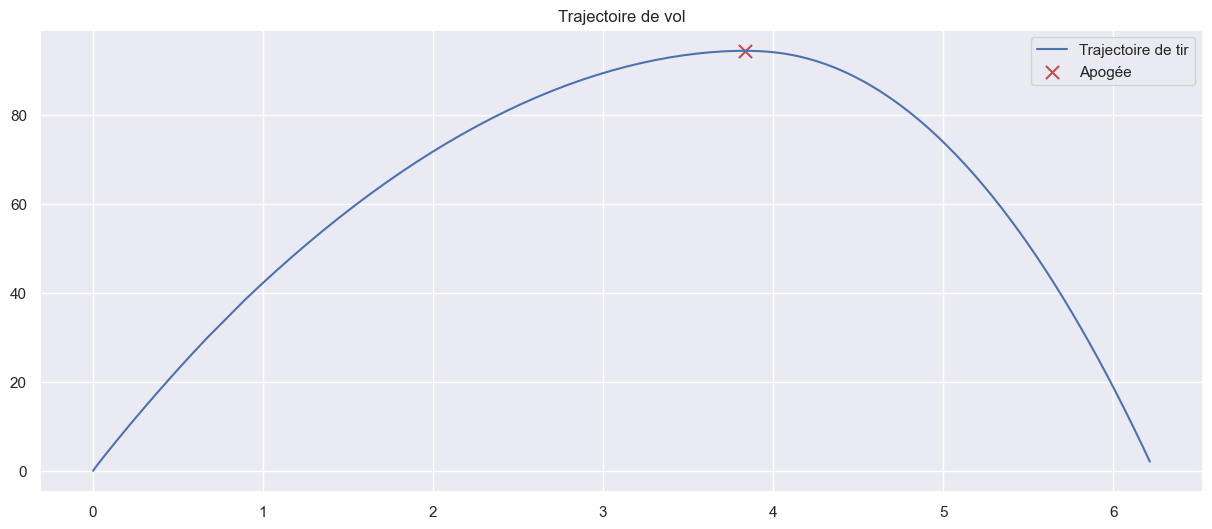

In [113]:
calcul_reel = tableau_complet[tableau_complet["y(t)"]>=0]
plt.figure()
plt.figure(figsize=(15,6))
plt.plot(calcul_reel["x(t)"],calcul_reel["y(t)"], label="Trajectoire de tir")
plt.scatter(calcul_reel["x(t)"].loc[calcul_reel["y(t)"].argmax()],calcul_reel["y(t)"].loc[calcul_reel["y(t)"].argmax()], label='Apogée', marker="x", s=90, c='r')
plt.legend()
plt.title("Trajectoire de vol")
plt.show()

#### Trajectoire décomposée

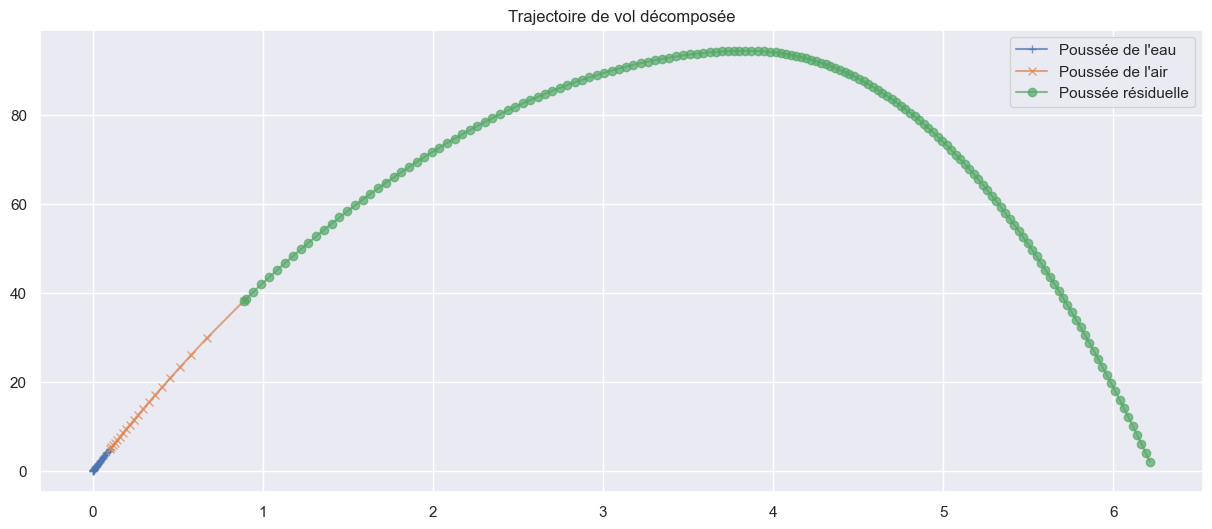

In [55]:
plt.figure(figsize=(15,6))
plt.plot(calcul_reel["x(t)"].loc[:29],calcul_reel["y(t)"].loc[:29], label="Poussée de l'eau", marker="+", alpha=0.7)
plt.plot(calcul_reel["x(t)"].loc[30:49],calcul_reel["y(t)"].loc[30:49], label="Poussée de l'air", marker="x", alpha=0.7)
plt.plot(calcul_reel["x(t)"].loc[50:],calcul_reel["y(t)"].loc[50:], label="Poussée résiduelle", marker="o", alpha=0.7)
plt.legend()
plt.title("Trajectoire de vol décomposée")
plt.show()

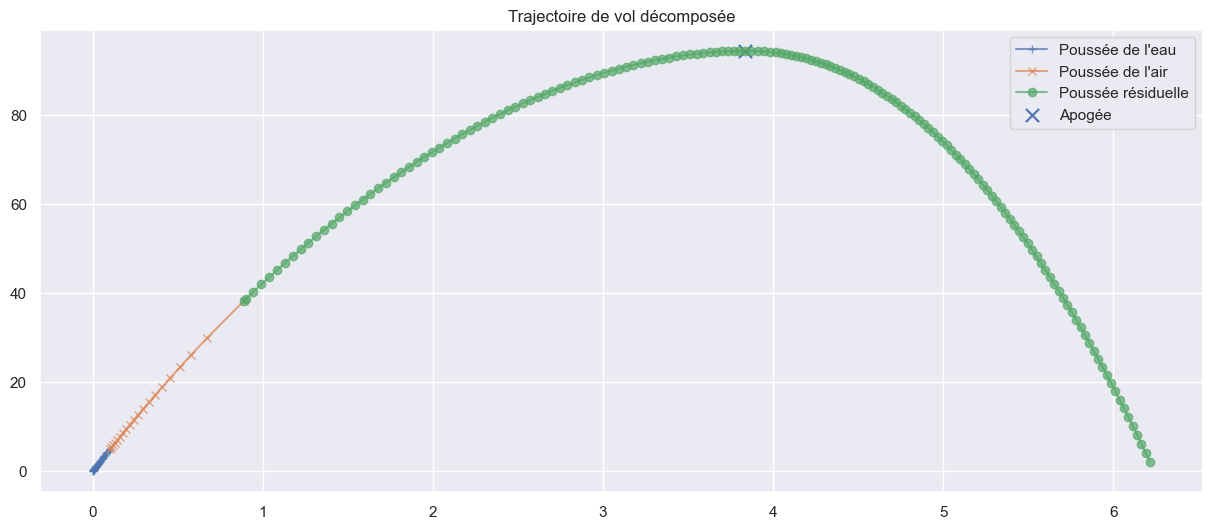

In [110]:
plt.figure(figsize=(15,6))
plt.plot(calcul_reel["x(t)"].loc[:29],calcul_reel["y(t)"].loc[:29], label="Poussée de l'eau", marker="+", alpha=0.7)
plt.plot(calcul_reel["x(t)"].loc[30:49],calcul_reel["y(t)"].loc[30:49], label="Poussée de l'air", marker="x", alpha=0.7)
plt.plot(calcul_reel["x(t)"].loc[50:],calcul_reel["y(t)"].loc[50:], label="Poussée résiduelle", marker="o", alpha=0.7)
plt.scatter(calcul_reel["x(t)"].loc[calcul_reel["y(t)"].argmax()],calcul_reel["y(t)"].loc[calcul_reel["y(t)"].argmax()], label='Apogée', marker="x", s=90)
plt.legend()
plt.title("Trajectoire de vol décomposée")
plt.show()

### Evolution de la vitesse

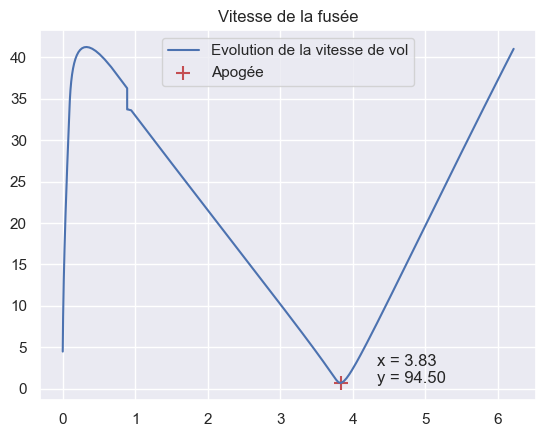

In [90]:
plt.figure()
plt.plot(calcul_reel["x(t)"],calcul_reel["Vitesse de la fusée"], label="Evolution de la vitesse de vol")
plt.scatter(calcul_reel["x(t)"].loc[119],calcul_reel["Vitesse de la fusée"].loc[119], marker="+", label="Apogée", c="r", s=90)
x_cast = "{:.2f}".format(calcul_reel["x(t)"].loc[calcul_reel["y(t)"].argmax()])
y_cast = "{:.2f}".format(calcul_reel["y(t)"].loc[calcul_reel["y(t)"].argmax()])
plt.text(calcul_reel["x(t)"].loc[119]+0.5,calcul_reel["Vitesse de la fusée"].loc[119], "x = {}\ny = {}".format(x_cast,y_cast))
plt.legend()
plt.title("Vitesse de la fusée")
plt.show()

### Poussée

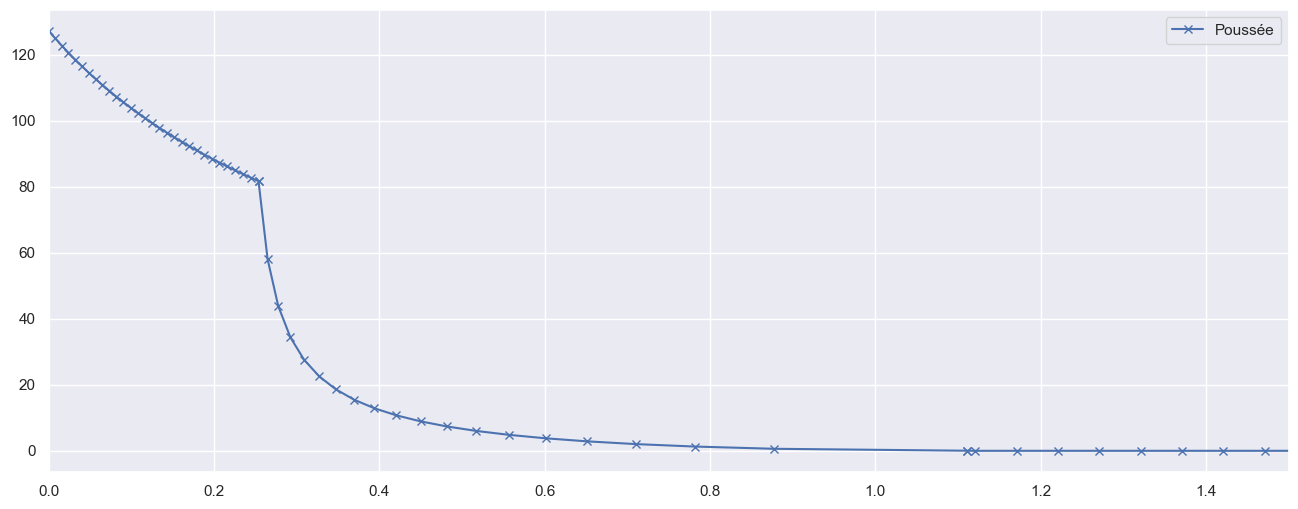

In [128]:
plt.figure(figsize=(16,6))
plt.plot(calcul_reel["Temps"],calcul_reel["Poussée"], marker = 'x', label="Poussée")
plt.legend()
plt.xlim(0,1.5)
plt.show()

### Vitesse d'éjection

#### Eau

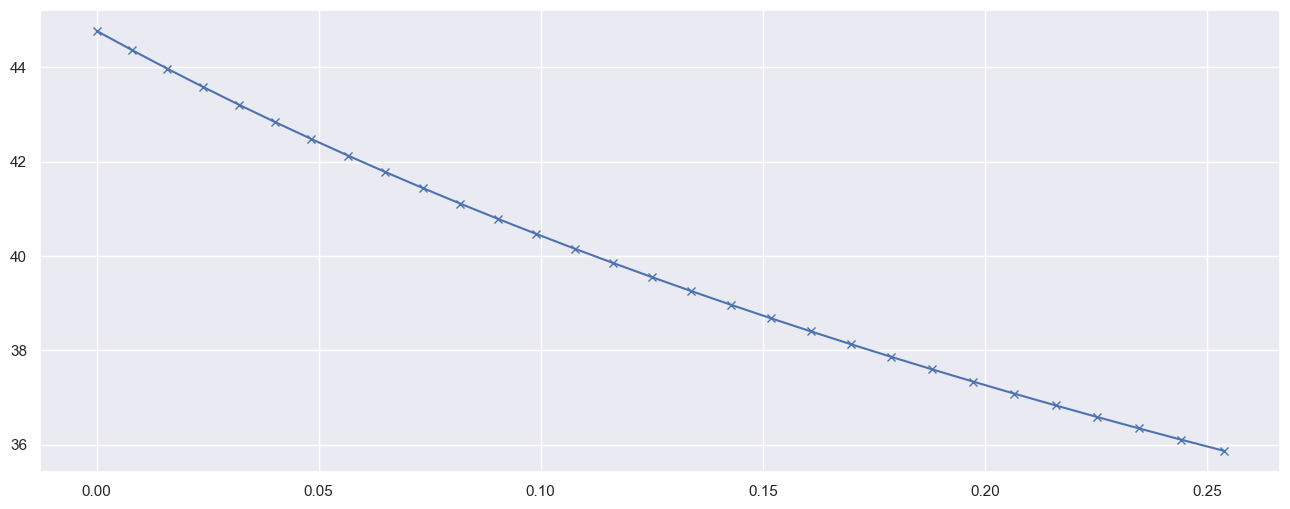

In [138]:
plt.figure(figsize=(16,6))
plt.plot(temps[:30], vitesse[0:30],marker='x')
plt.show()

#### Air

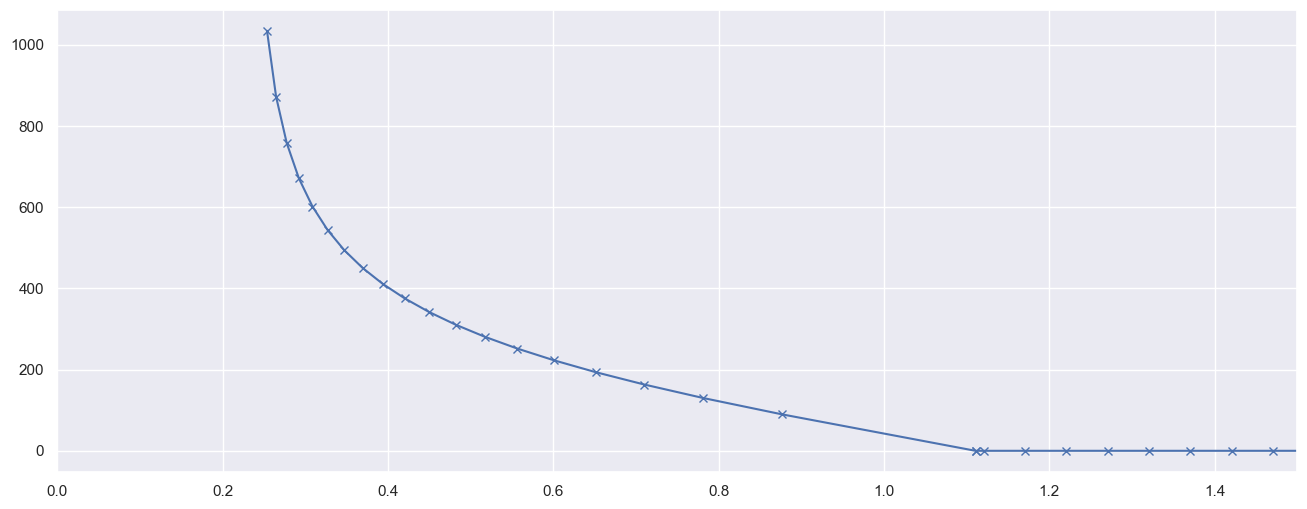

In [139]:
plt.figure(figsize=(16,6))
plt.plot(temps[30:], vitesse[30:],marker='x')
plt.xlim(0,1.5)
plt.show()

### Vitesse de la fusée

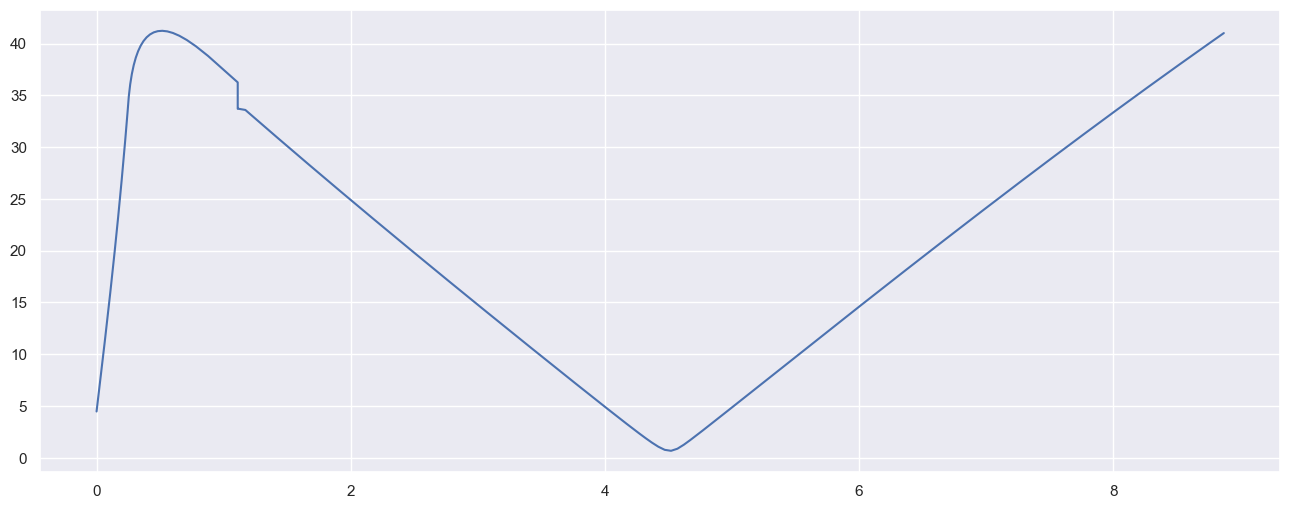

In [143]:
plt.figure(figsize=(16,6))
plt.plot(calcul_reel["Temps"],calcul_reel["Vitesse de la fusée"])
plt.show()